<a href="https://colab.research.google.com/github/JeromeHoen/OC_P4-Anticipez_le_retard_de_vol_des_avions/blob/master/Notebook_P4_Analyse_exploratoire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Anticipez le retard de vol des avions : Exploration

##Import des fonctions et du DataFrame

In [1]:
# data management
import pandas as pd    
import numpy as np
import scipy

# data viz
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("darkgrid")

from plotly.offline import download_plotlyjs, plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline()

# google colab modules

from google.colab import files

def configure_plotly_browser_state():
    import IPython
    display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))
  
    
# ML algortihms

# text extraction and transformation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# data standardization
from sklearn.preprocessing import StandardScaler, QuantileTransformer

# scoring and cross-validation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# dimension reduction 
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding, MDS
from umap import UMAP

# binary value prediction
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

# clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import KNeighborsClassifier

# distance calculation
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors

# bayesian optimization
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization

# performance
from functools import wraps
import time

def timing(f):
    @wraps(f)
    def wrap(*args, **kwargs):
        t_start = time.time()
        result = f(*args, **kwargs)
        t_end = time.time()
        print(f"function {f.__name__} with args {args}, kwargs {kwargs} took {t_end - t_start: 0.4f} sec.")
        return result
    return wrap

  Stored in directory: /root/.cache/pip/wheels/1d/0d/3b/6b9d4477a34b3905f246ff4e7acf6aafd4cc9b77d473629b77
Successfully built bayesian-optimization


In [0]:
# custom functions

from matplotlib.collections import LineCollection
from scipy.cluster.hierarchy import dendrogram

def full_print(*arg, columns=20, rows=60, colwidth=50):
    """Set pandas.option_context and display a DataFrame"""
    with pd.option_context('display.max_columns', columns,
                           'display.max_rows', rows,
                           'display.max_colwidth', colwidth):
        display(*arg)

def delete_rows_csr(mat, indices):
    """
    Remove the rows denoted by ``indices`` form the CSR sparse matrix ``mat``.
    """
    if not isinstance(mat, scipy.sparse.csr_matrix):
        raise ValueError("works only for CSR format -- use .tocsr() first")
    indices = list(indices)
    mask = np.ones(mat.shape[0], dtype=bool)
    mask[indices] = False
    return mat[mask]

def filter_rows_csr(mat, indices):
    """
    Keep the rows denoted by ``indices`` form the CSR sparse matrix ``mat``.
    """
    if not isinstance(mat, scipy.sparse.csr_matrix):
        raise ValueError("works only for CSR format -- use .tocsr() first")
    indices = list(indices)
    mask = np.zeros(mat.shape[0], dtype=bool)
    mask[indices] = True
    return mat[mask]
        
def display_circles(pca, axis_ranks=[(0, 1)], labels=None, label_rotation=0, lims=None):
    pcs = pca.components_
    n_comp = pca.n_components_
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

def plot_dendrogram(Z, names):
    plt.figure(figsize=(10,25))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('distance')
    dendrogram(
        Z,
        labels = names,
        orientation = "left",
    )
    plt.show()

In [3]:
!wget https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Anticipez+le+retard+de+vol+des+avions+-+109/Dataset+Projet+4.zip
!unzip Dataset+Projet+4.zip

--2019-07-09 09:37:50--  https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Anticipez+le+retard+de+vol+des+avions+-+109/Dataset+Projet+4.zip
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.108.187
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.108.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 279971689 (267M) [application/x-www-form-urlencoded]
Saving to: ‘Dataset+Projet+4.zip’

Dataset+Projet+4.zi 100%[===================>] 267.00M  31.3MB/s    in 9.3s    

2019-07-09 09:38:00 (28.7 MB/s) - ‘Dataset+Projet+4.zip’ saved [279971689/279971689]

Archive:  Dataset+Projet+4.zip
  inflating: 2016_01.csv             
  inflating: 2016_02.csv             
  inflating: 2016_03.csv             
  inflating: 2016_04.csv             
  inflating: 2016_05.csv             
  inflating: 2016_06.csv             
  inflating: 2016_07.csv             
  infla

In [0]:
import glob, os
                
all_files = glob.glob(os.path.join(os.getcwd(), "2016_*.csv"))

In [0]:
dtypes = {    
    'YEAR': np.int64,
    'QUARTER': np.int64,
    'MONTH': np.int64,
    'DAY_OF_MONTH': np.int64,
    'DAY_OF_WEEK': np.int64,
    'FL_DATE': str,
    'UNIQUE_CARRIER': str,
    'AIRLINE_ID': np.int64,
    'CARRIER': str,
    'TAIL_NUM': str,
    'FL_NUM': np.int64,
    'ORIGIN_AIRPORT_ID': np.int64,
    'ORIGIN_AIRPORT_SEQ_ID': np.int64,
    'ORIGIN_CITY_MARKET_ID': np.int64,
    'ORIGIN': str,
    'ORIGIN_CITY_NAME': str,
    'ORIGIN_STATE_ABR': str,
    'ORIGIN_STATE_FIPS': np.float64,
    'ORIGIN_STATE_NM': str,
    'ORIGIN_WAC': np.int64,
    'DEST_AIRPORT_ID': np.int64,
    'DEST_AIRPORT_SEQ_ID': np.int64,
    'DEST_CITY_MARKET_ID': np.int64,
    'DEST': str,
    'DEST_CITY_NAME': str,
    'DEST_STATE_ABR': str,
    'DEST_STATE_FIPS': np.float64,
    'DEST_STATE_NM': str,
    'DEST_WAC': np.float64,
    'CRS_DEP_TIME': np.float64,
    'DEP_TIME': str,
    'DEP_DELAY': np.float64,
    'DEP_DELAY_NEW': np.float64,
    'DEP_DEL15': np.float64,
    'DEP_DELAY_GROUP': np.float64,
    'DEP_TIME_BLK': str,
    'TAXI_OUT': np.float64,
    'WHEELS_OFF': np.float64,
    'WHEELS_ON': np.float64,
    'TAXI_IN': np.float64,
    'CRS_ARR_TIME': np.float64,
    'ARR_TIME': str,
    'ARR_DELAY': np.float64,
    'ARR_DELAY_NEW': np.float64,
    'ARR_DEL15': np.float64,
    'ARR_DELAY_GROUP': np.float64,
    'ARR_TIME_BLK': str,
    'CANCELLED': np.float64,
    'CANCELLATION_CODE': str,
    'DIVERTED': np.float64,
    'CRS_ELAPSED_TIME': np.float64,
    'ACTUAL_ELAPSED_TIME': np.float64,
    'AIR_TIME': np.float64,
    'FLIGHTS': np.float64,
    'DISTANCE': np.float64,
    'DISTANCE_GROUP': np.float64,
    'CARRIER_DELAY': np.float64,
    'WEATHER_DELAY': np.float64,
    'NAS_DELAY': np.float64,
    'SECURITY_DELAY': np.float64,
    'LATE_AIRCRAFT_DELAY': np.float64,
    'FIRST_DEP_TIME': np.float64,
    'TOTAL_ADD_GTIME': np.float64,
    'LONGEST_ADD_GTIME': np.float64,
}

In [6]:
df = pd.concat((pd.read_csv(f, error_bad_lines=False, parse_dates=['FL_DATE']) for f in all_files), ignore_index=True)

# drop last column
last_col_name = df.columns[-1]
df.drop(columns=last_col_name, inplace=True)

# drop rows where FLIGHTS != 1 (corrupted)
df = df[df.FLIGHTS == 1].reset_index(drop=True)

# convert flight date and force dtype on columns
df.FL_DATE = pd.to_datetime(df.FL_DATE).dt.strftime('%Y-%m-%d')

for col, dtype in dtypes.items():
    df[col] = df[col].astype(dtype)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DtypeWarning:

Columns (48) have mixed types. Specify dtype option on import or set low_memory=False.

b'Skipping line 121012: expected 65 fields, saw 75\n'
b'Skipping line 386249: expected 65 fields, saw 83\nSkipping line 388291: expected 65 fields, saw 78\nSkipping line 389371: expected 65 fields, saw 72\nSkipping line 389548: expected 65 fields, saw 81\n'
b'Skipping line 453858: expected 65 fields, saw 97\n'
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DtypeWarning:

Columns (0,1,3,4,10,11,13,19,20,21,22,30,36,41,48) have mixed types. Specify dtype option on import or set low_memory=False.



##Analyse exploratoire

In [12]:
df.sample(5)

YEAR  QUARTER  ...  TOTAL_ADD_GTIME  LONGEST_ADD_GTIME
1518124  2016        3  ...              NaN                NaN
1418339  2016        3  ...              NaN                NaN
2045948  2016        3  ...              NaN                NaN
3581523  2016        4  ...              NaN                NaN
4315393  2016        2  ...              NaN                NaN

[5 rows x 64 columns]

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5635973 entries, 0 to 5635972
Data columns (total 64 columns):
YEAR                     int64
QUARTER                  int64
MONTH                    int64
DAY_OF_MONTH             int64
DAY_OF_WEEK              int64
FL_DATE                  object
UNIQUE_CARRIER           object
AIRLINE_ID               int64
CARRIER                  object
TAIL_NUM                 object
FL_NUM                   int64
ORIGIN_AIRPORT_ID        int64
ORIGIN_AIRPORT_SEQ_ID    int64
ORIGIN_CITY_MARKET_ID    int64
ORIGIN                   object
ORIGIN_CITY_NAME         object
ORIGIN_STATE_ABR         object
ORIGIN_STATE_FIPS        float64
ORIGIN_STATE_NM          object
ORIGIN_WAC               int64
DEST_AIRPORT_ID          int64
DEST_AIRPORT_SEQ_ID      int64
DEST_CITY_MARKET_ID      int64
DEST                     object
DEST_CITY_NAME           object
DEST_STATE_ABR           object
DEST_STATE_FIPS          float64
DEST_STATE_NM            object
DES

In [13]:
df.describe([.01, .1, .25, .5, .75, .9, .99], include='number')

YEAR       QUARTER  ...  TOTAL_ADD_GTIME  LONGEST_ADD_GTIME
count  5635973.0  5.635973e+06  ...     34533.000000       34533.000000
mean      2016.0  2.489490e+00  ...        35.485072          34.968407
std          0.0  1.123128e+00  ...        31.122975          30.092505
min       2016.0  1.000000e+00  ...         1.000000           1.000000
1%        2016.0  1.000000e+00  ...         3.000000           3.000000
10%       2016.0  1.000000e+00  ...        10.000000          10.000000
25%       2016.0  1.000000e+00  ...        16.000000          16.000000
50%       2016.0  3.000000e+00  ...        26.000000          26.000000
75%       2016.0  3.000000e+00  ...        43.000000          42.000000
90%       2016.0  4.000000e+00  ...        74.000000          73.000000
99%       2016.0  4.000000e+00  ...       152.000000         150.000000
max       2016.0  4.000000e+00  ...       335.000000         265.000000

[12 rows x 49 columns]

In [0]:
sample_df = df.sample(100000)

In [15]:
means = sample_df.drop(columns=['YEAR', 'MONTH']).mean(numeric_only=True)
monthly_means = sample_df.groupby(['YEAR', 'MONTH']).mean()
monthly_average_dev = (monthly_means - means) / means
monthly_average_dev

ACTUAL_ELAPSED_TIME  AIRLINE_ID  ...  WHEELS_OFF  WHEELS_ON
YEAR MONTH                                   ...                       
2016 1                -0.002790   -0.000274  ...   -0.000247   0.008009
     2                 0.011634    0.000229  ...    0.000035   0.005219
     3                 0.012024    0.002072  ...    0.004010   0.002001
     4                -0.028561   -0.003309  ...   -0.002309   0.001247
     5                -0.006005    0.000345  ...    0.006176   0.000541
     6                 0.015772   -0.000226  ...    0.002367  -0.011848
     7                 0.007012   -0.000052  ...    0.003875  -0.015579
     8                 0.013478   -0.000160  ...   -0.004122  -0.006499
     9                -0.018183    0.000149  ...   -0.006579   0.001585
     10               -0.022714   -0.000045  ...   -0.004872   0.008978
     11               -0.019144    0.000032  ...   -0.001062   0.006125
     12                0.026734   -0.000052  ...    0.000500   0.003221

[12 rows x 47 columns]

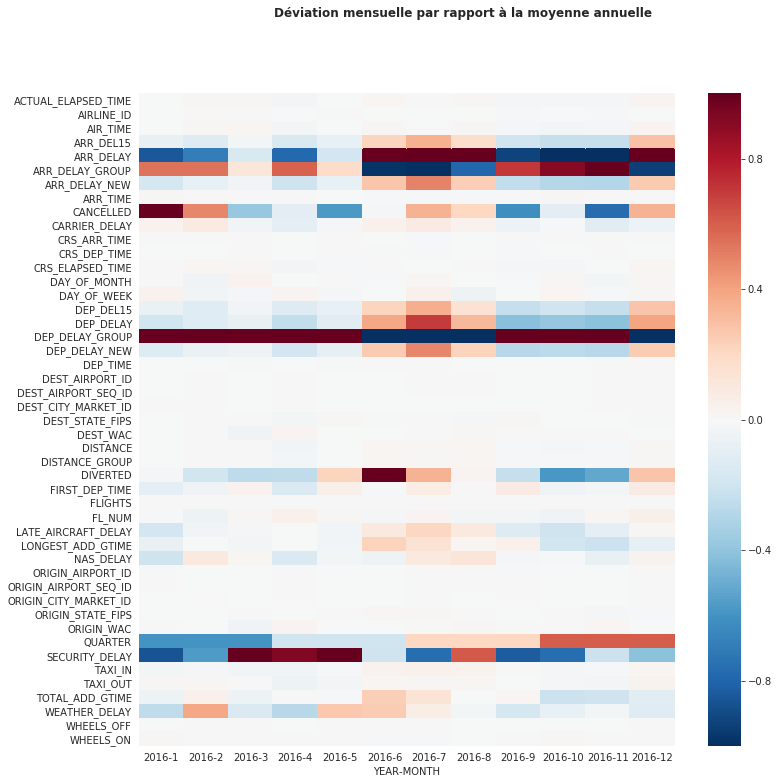

In [16]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(monthly_average_dev.transpose(), cmap='RdBu_r', vmin=-1, vmax=1, ax=ax)
plt.suptitle('Déviation mensuelle par rapport à la moyenne annuelle', weight='bold')
plt.show()

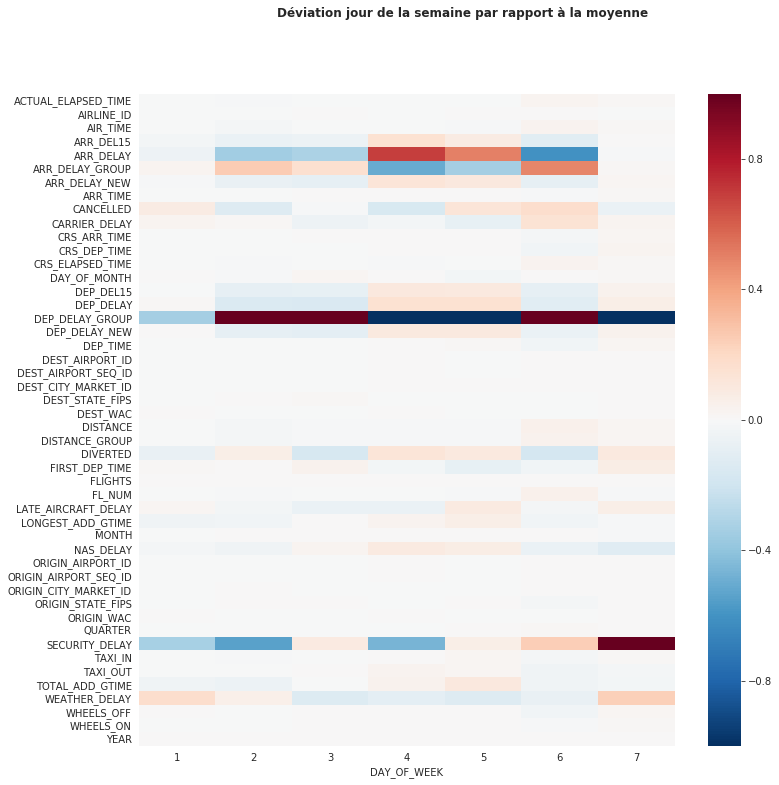

In [17]:
means = sample_df.drop(columns=['DAY_OF_WEEK']).mean(numeric_only=True)
dow_means = sample_df.groupby(['DAY_OF_WEEK']).mean()
dow_average_dev = (dow_means - means) / means

fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(dow_average_dev.transpose(), cmap='RdBu_r', vmin=-1, vmax=1, ax=ax)
plt.suptitle('Déviation jour de la semaine par rapport à la moyenne', weight='bold')
plt.show()

In [18]:
df.AIRLINE_ID.value_counts()

19393    1296854
19790     970822
19805     886057
20304     604283
19977     545067
20366     503343
20409     284666
19930     166957
20416     138199
20436      95857
19690      76536
21171      67332
Name: AIRLINE_ID, dtype: int64

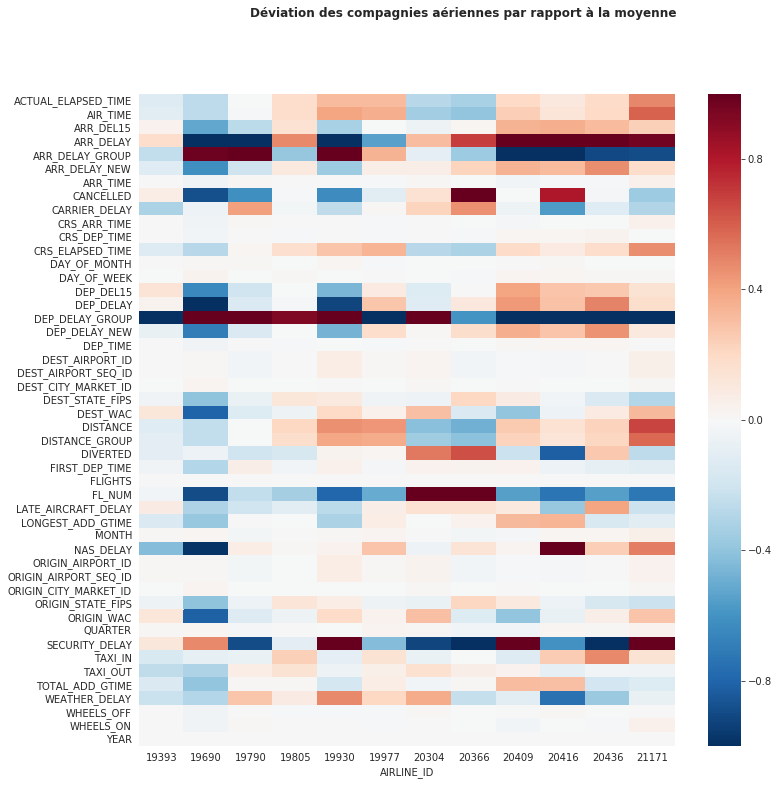

In [19]:
means = sample_df.drop(columns=['AIRLINE_ID']).mean(numeric_only=True)
airline_means = sample_df.groupby(['AIRLINE_ID']).mean()
airline_average_dev = (airline_means - means) / means

fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(airline_average_dev.transpose(), cmap='RdBu_r', vmin=-1, vmax=1, ax=ax)
plt.suptitle('Déviation des compagnies aériennes par rapport à la moyenne', weight='bold')
plt.show()

In [20]:
print(f"Nombre d'aéroports (départ): {df.ORIGIN_AIRPORT_ID.nunique()}")
print(f"Nombre d'aéroports (arrivée): {df.DEST_AIRPORT_ID.nunique()}")
print(f"Nombre de liaisons: {df[['ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'FLIGHTS']].groupby(['ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID']).size().shape[0]}")

Nombre d'aéroports (départ): 313
Nombre d'aéroports (arrivée): 310
Nombre de liaisons: 4591


In [18]:
import holidays
us_holidays = holidays.US()

days = df.FL_DATE.unique()
holidays = [date for date in days if date in us_holidays]
print(f"nombre de jours dans la base: {len(days)}")
print(f"dont {len(holidays)} jours fériés")

nombre de jours dans la base: 366
dont 11 jours fériés


In [0]:
df['IS_HOLIDAY'] = 0
for holiday in holidays:
    df.loc[df[df.FL_DATE == holiday].index, 'IS_HOLIDAY'] = 1

In [25]:
df['IS_HOLIDAY'].value_counts()

0    5477795
1     158178
Name: IS_HOLIDAY, dtype: int64

In [0]:
df['DAY_OF_WEEK_H'] = df['DAY_OF_WEEK'].astype(str)
df.loc[df[df['IS_HOLIDAY']==1].index, 'DAY_OF_WEEK_H'] = 'H'

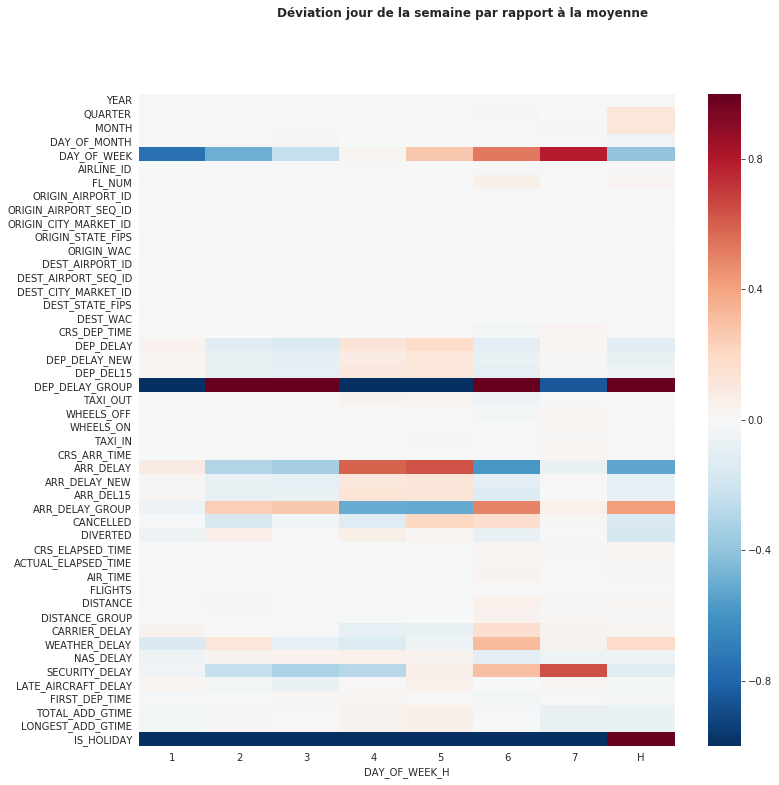

In [10]:
means = df.drop(columns=['DAY_OF_WEEK_H']).mean(numeric_only=True)
dowh_means = df.groupby(['DAY_OF_WEEK_H']).mean()
dowh_average_dev = (dowh_means - means) / means

fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(dowh_average_dev.transpose(), cmap='RdBu_r', vmin=-1, vmax=1, ax=ax)
plt.suptitle('Déviation jour de la semaine par rapport à la moyenne', weight='bold')
plt.show()

In [0]:
states_flights = df[['ORIGIN_STATE_ABR', 'DEST_STATE_ABR', 'FLIGHTS']].groupby(['ORIGIN_STATE_ABR', 'DEST_STATE_ABR']).sum()

In [0]:
states = sorted(df.ORIGIN_STATE_ABR.unique())

In [0]:
total_flights = {}
for state in states:
    incoming = states_flights[states_flights.index.get_level_values(0) == state].FLIGHTS.sum()
    outgoing = states_flights[states_flights.index.get_level_values(1) == state].FLIGHTS.sum()
    total_flights[state] = incoming + outgoing

In [16]:
total_flights

{'AK': 69114.0,
 'AL': 50246.0,
 'AR': 32820.0,
 'AZ': 352031.0,
 'CA': 1450901.0,
 'CO': 496322.0,
 'CT': 40775.0,
 'FL': 900109.0,
 'GA': 819910.0,
 'HI': 200816.0,
 'IA': 24542.0,
 'ID': 42214.0,
 'IL': 684776.0,
 'IN': 78650.0,
 'KS': 18083.0,
 'KY': 64067.0,
 'LA': 135087.0,
 'MA': 245271.0,
 'MD': 192287.0,
 'ME': 13972.0,
 'MI': 309001.0,
 'MN': 277439.0,
 'MO': 205574.0,
 'MS': 22815.0,
 'MT': 34312.0,
 'NC': 311454.0,
 'ND': 25601.0,
 'NE': 43117.0,
 'NH': 13431.0,
 'NJ': 245418.0,
 'NM': 42663.0,
 'NV': 330054.0,
 'NY': 509122.0,
 'OH': 139263.0,
 'OK': 62384.0,
 'OR': 135379.0,
 'PA': 211255.0,
 'PR': 59287.0,
 'RI': 25364.0,
 'SC': 65089.0,
 'SD': 16158.0,
 'TN': 160780.0,
 'TT': 978.0,
 'TX': 1165038.0,
 'UT': 226516.0,
 'VA': 288531.0,
 'VI': 12206.0,
 'VT': 8302.0,
 'WA': 288504.0,
 'WI': 102277.0,
 'WV': 5212.0,
 'WY': 17429.0}

In [0]:
top_states = sorted(total_flights, key=total_flights.get, reverse=True)[:7]

In [0]:
states_flights['NEW_ORIGIN'] = states_flights.index.get_level_values(0)
states_flights['NEW_DEST'] = states_flights.index.get_level_values(1)

states_flights.loc[~states_flights.index.get_level_values(0).isin(top_states), 'NEW_ORIGIN'] = 'other'
states_flights.loc[~states_flights.index.get_level_values(1).isin(top_states), 'NEW_DEST'] = 'other'

states_flights.loc[(states_flights['NEW_DEST']=='other') & (states_flights.index.get_level_values(0) == states_flights.index.get_level_values(1)), 'NEW_DEST'] = 'same state'

In [81]:
states_flights

FLIGHTS NEW_ORIGIN    NEW_DEST
ORIGIN_STATE_ABR DEST_STATE_ABR                                
AK               AK              18657.0      other  same state
                 AZ                291.0      other       other
                 CA                740.0      other          CA
                 CO                456.0      other          CO
                 GA                108.0      other          GA
                 HI                431.0      other       other
                 IL                670.0      other          IL
                 MN                709.0      other       other
                 NJ                 10.0      other       other
                 NV                 68.0      other       other
                 OR               1018.0      other       other
                 TX                194.0      other          TX
                 UT                 92.0      other       other
                 WA              11116.0      other       other
AL               AZ                  2.0      other       other
                 CO                365.0      other          CO
                 FL               1401.0      other          FL
                 GA              12606.0      other          GA
                 IL               2244.0      other          IL
                 MD                383.0      other       other
                 MI                942.0      other       other
                 NV                392.0      other       other
                 NY                549.0      other          NY
                 TX               6275.0      other          TX
AR               AZ                365.0      other       other
                 CA                346.0      other          CA
                 CO               1301.0      other          CO
                 GA               4907.0      other          GA
                 IL               1850.0      other          IL
                 IN                  1.0      other       other
...                                  ...        ...         ...
WI               MD                936.0      other       other
                 MI               5615.0      other       other
                 MN               7617.0      other       other
                 MO               1086.0      other       other
                 NC                  1.0      other       other
                 NJ               1701.0      other       other
                 NV               1476.0      other       other
                 NY               1138.0      other          NY
                 OH                553.0      other       other
                 PA                 64.0      other       other
                 TX               2325.0      other          TX
                 UT                281.0      other       other
                 VA                969.0      other       other
                 WA                780.0      other       other
                 WI                  1.0      other  same state
WV               GA               1654.0      other          GA
                 IL                571.0      other          IL
                 SC                 42.0      other       other
                 TX                337.0      other          TX
WY               CA                517.0      other          CA
                 CO               3676.0      other          CO
                 GA                116.0      other          GA
                 IL                547.0      other          IL
                 MN                117.0      other       other
                 NJ                 78.0      other       other
                 NY                 12.0      other          NY
                 TX                561.0      other          TX
                 UT               3053.0      other       other
                 VA                  8.0      other       other
                 WA                 30.0      other       other



In [82]:
states_flights_simplified = states_flights.groupby(['NEW_ORIGIN', 'NEW_DEST']).sum()
states_flights_simplified

FLIGHTS
NEW_ORIGIN NEW_DEST             
CA         CA           227213.0
           CO            38676.0
           FL            13855.0
           GA            15097.0
           IL            32143.0
           NY            25371.0
           TX            60468.0
           other        312686.0
CO         CA            38775.0
           CO            15439.0
           FL             9108.0
           GA             6942.0
           IL            11576.0
           NY             5152.0
           TX            27547.0
           other        133563.0
FL         CA            13886.0
           CO             9110.0
           FL            19254.0
           GA            66145.0
           IL            25496.0
           NY            59936.0
           TX            44195.0
           other        212009.0
GA         CA            15095.0
           CO             6906.0
           FL            66181.0
           GA            21431.0
           IL            16211.0
           NY            19332.0
...                          ...
IL         GA            16412.0
           IL             5339.0
           NY            21091.0
           TX            22074.0
           other        208557.0
NY         CA            25379.0
           CO             5127.0
           FL            59872.0
           GA            19297.0
           IL            21160.0
           NY            11745.0
           TX            13532.0
           other         98324.0
TX         CA            60916.0
           CO            26739.0
           FL            44552.0
           GA            28027.0
           IL            22923.0
           NY            13576.0
           TX           143129.0
           other        242589.0
other      CA           312382.0
           CO           134373.0
           FL           211918.0
           GA           236427.0
           IL           207521.0
           NY            98483.0
           TX           243767.0
           other       1027418.0
           same state   150616.0

[65 rows x 1 columns]

In [83]:
new_states_list = top_states + ['other', 'same state']
position_dict = {}

for i, state in enumerate(new_states_list):
    position_dict['from ' + state] = i * 2
    position_dict['to ' + state] = i * 2 + 1

position_dict

{'from CA': 0,
 'from CO': 12,
 'from FL': 4,
 'from GA': 6,
 'from IL': 8,
 'from NY': 10,
 'from TX': 2,
 'from other': 14,
 'from same state': 16,
 'to CA': 1,
 'to CO': 13,
 'to FL': 5,
 'to GA': 7,
 'to IL': 9,
 'to NY': 11,
 'to TX': 3,
 'to other': 15,
 'to same state': 17}

In [0]:
label = sorted(position_dict, key=position_dict.get)
source = ('from ' + states_flights_simplified.index.get_level_values(0)).map(position_dict)
target = ('to ' + states_flights_simplified.index.get_level_values(1)).map(position_dict)

In [86]:
configure_plotly_browser_state()

data = dict(
    type='sankey',
    node = dict(
      pad = 10,
      thickness = 20,
      line = dict(
        color = "black",
        width = 1
      ),
      label = label,
      color = 'blue'
    ),
    link = dict(
      source = source,
      target = target,
      value = states_flights_simplified.FLIGHTS
  ))

layout =  dict(
    title = "Liaisions inter-Etats",
    font = dict(
      size = 10
    )
)

fig = dict(data=[data], layout=layout)
iplot(fig, validate=False)

In [0]:
airports = pd.read_csv('https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat', header=None, index_col=0)

In [0]:
airports.head()

In [0]:
us_airports = list(set(list(df.DEST.unique()) + list(df.ORIGIN.unique())))

In [0]:
len(us_airports)

In [0]:
airports_coords = airports[airports.loc[:,4].isin(us_airports)].loc[:,[1,4,6,7,9,10,11]]
airports_coords.head()

In [0]:
airports_coords.columns = ['AIRPORT', 'IATA', 'LATITUDE', 'LONGITUDE', 'TIMEZONE', 'DST', 'TZ_DATABASE']
airports_coords.reset_index(drop=True, inplace=True)
airports_coords.head()

In [0]:
coords_flights = df[['ORIGIN', 'DEST', 'FL_DATE', 'FLIGHTS']]
coords_flights.head()

In [0]:
iata_latitude = dict(airports_coords[['IATA', 'LATITUDE']].values)
iata_longitude = dict(airports_coords[['IATA', 'LONGITUDE']].values)

In [0]:
coords_flights['ORIGIN_LAT'] = coords_flights['ORIGIN'].map(iata_latitude)
coords_flights['ORIGIN_LON'] = coords_flights['ORIGIN'].map(iata_longitude)
coords_flights['DEST_LAT'] = coords_flights['DEST'].map(iata_latitude)
coords_flights['DEST_LON'] = coords_flights['DEST'].map(iata_longitude)

In [0]:
coords_flights.head()

In [0]:
coords_flights.columns

In [0]:
coords_flights.groupby(
    ['ORIGIN', 'DEST', 'FL_DATE', 'ORIGIN_LAT', 'ORIGIN_LON',
     'DEST_LAT', 'DEST_LON']).sum().to_csv('coords_flights.csv', sep=';', decimal=',')

In [0]:
files.download('coords_flights.csv')

In [0]:
df.columns

Index(['YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE',
       'UNIQUE_CARRIER', 'AIRLINE_ID', 'CARRIER', 'TAIL_NUM', 'FL_NUM',
       'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN_CITY_MARKET_ID',
       'ORIGIN', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'ORIGIN_STATE_FIPS',
       'ORIGIN_STATE_NM', 'ORIGIN_WAC', 'DEST_AIRPORT_ID',
       'DEST_AIRPORT_SEQ_ID', 'DEST_CITY_MARKET_ID', 'DEST', 'DEST_CITY_NAME',
       'DEST_STATE_ABR', 'DEST_STATE_FIPS', 'DEST_STATE_NM', 'DEST_WAC',
       'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DEL15',
       'DEP_DELAY_GROUP', 'DEP_TIME_BLK', 'TAXI_OUT', 'WHEELS_OFF',
       'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY',
       'ARR_DELAY_NEW', 'ARR_DEL15', 'ARR_DELAY_GROUP', 'ARR_TIME_BLK',
       'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME',
       'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'FLIGHTS', 'DISTANCE',
       'DISTANCE_GROUP', 'CARRIER_DELAY', 'WEATHER_DELAY

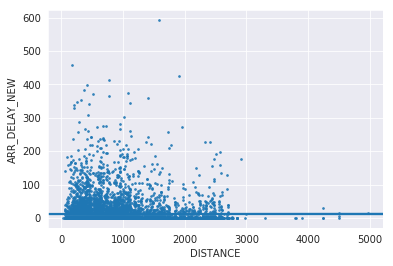

In [0]:
sns.regplot('DISTANCE', 'ARR_DELAY_NEW', df.sample(10000), scatter_kws={'s': 3})

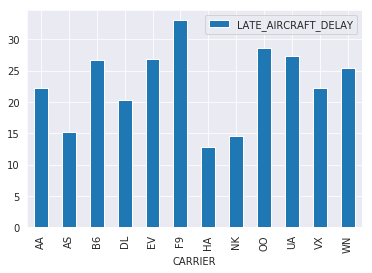

In [25]:
df[['CARRIER', 'LATE_AIRCRAFT_DELAY']].groupby('CARRIER').mean().plot.bar()

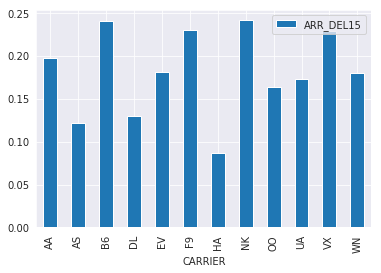

In [24]:
df[['CARRIER', 'ARR_DEL15']].groupby('CARRIER').mean().plot.bar()

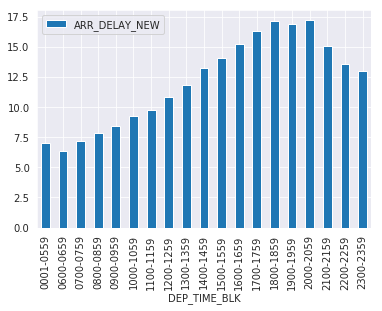

In [87]:
df[['DEP_TIME_BLK', 'ARR_DELAY_NEW']].groupby('DEP_TIME_BLK').mean().plot.bar()

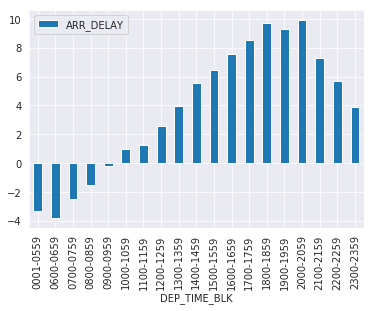

In [88]:
df[['DEP_TIME_BLK', 'ARR_DELAY']].groupby('DEP_TIME_BLK').mean().plot.bar()

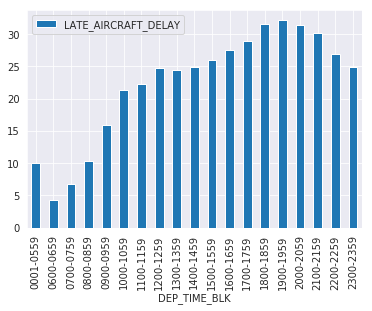

In [90]:
df[['DEP_TIME_BLK', 'LATE_AIRCRAFT_DELAY']].groupby('DEP_TIME_BLK').mean().plot.bar()

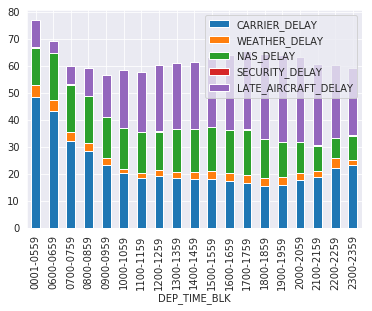

In [92]:
df[['DEP_TIME_BLK', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY',
    'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']].groupby('DEP_TIME_BLK').mean().plot(kind='bar', stacked=True)

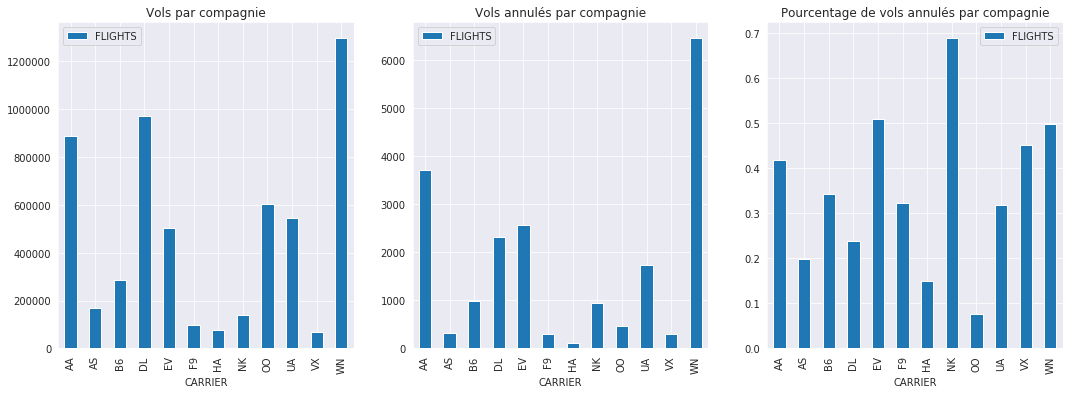

In [18]:
fig, ax = plt.subplots(1,3, figsize=(18,6))
df.loc[:,['CARRIER', 'FLIGHTS']].groupby('CARRIER').sum().plot(kind='bar', title='Vols par compagnie', ax=ax[0])
df.loc[df.CANCELLATION_CODE == "A", ['CARRIER', 'FLIGHTS']].groupby('CARRIER').sum().plot(kind='bar', title='Vols annulés par compagnie', ax=ax[1])
(100 * df.loc[df.CANCELLATION_CODE == "A", ['CARRIER', 'FLIGHTS']].groupby('CARRIER').sum() / df.loc[:,['CARRIER', 'FLIGHTS']].groupby('CARRIER').sum()).plot(kind='bar', title='Pourcentage de vols annulés par compagnie', ax=ax[2])

In [8]:
df.sample(5)

YEAR  QUARTER  ...  TOTAL_ADD_GTIME  LONGEST_ADD_GTIME
741507   2016        4  ...              NaN                NaN
2637055  2016        2  ...              NaN                NaN
198119   2016        1  ...              NaN                NaN
1920496  2016        3  ...              NaN                NaN
540083   2016        4  ...              NaN                NaN

[5 rows x 64 columns]

In [26]:
df.query('CANCELLED == 1').ARR_DELAY_NEW.sum()

0.0

In [27]:
df.query('DIVERTED == 1').ARR_DELAY_NEW.sum()

0.0

In [0]:
valid_index = df.query('DIVERTED == 0 and CANCELLED == 0').index

In [0]:
sum_delays = df.loc[valid_index, ['CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']].fillna(0).sum(axis=1)

In [0]:
sample_index = df['FLIGHTS'].sample(1000).index

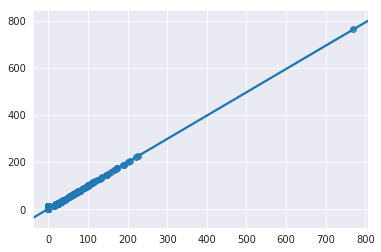

In [17]:
sns.regplot(x=sum_delays[sample_index].values,
            y=df.loc[sample_index, 'ARR_DELAY_NEW'].values)

In [31]:
r2_score(df.loc[valid_index, 'ARR_DELAY_NEW'].fillna(0), sum_delays)

0.993859166926663

In [32]:
np.sqrt(mean_squared_error(df.loc[valid_index, 'ARR_DELAY_NEW'].fillna(0), sum_delays))

3.0101648672871724

In [0]:
diff_delay = np.abs(df.loc[valid_index, 'ARR_DELAY_NEW'].fillna(0) - sum_delays)
diff_index = diff_delay[diff_delay > 0].index

In [38]:
df[df.index.isin(diff_index)].sample(5)

YEAR  QUARTER  ...  TOTAL_ADD_GTIME  LONGEST_ADD_GTIME
2567306  2016        2  ...              NaN                NaN
2279565  2016        3  ...              NaN                NaN
4044005  2016        4  ...              NaN                NaN
3225472  2016        3  ...              NaN                NaN
1731638  2016        3  ...              NaN                NaN

[5 rows x 64 columns]

In [52]:
tmp = df.query('ARR_DELAY_NEW == 0')
tmp[['CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']].count()

CARRIER_DELAY          0
WEATHER_DELAY          0
NAS_DELAY              0
SECURITY_DELAY         0
LATE_AIRCRAFT_DELAY    0
dtype: int64

Pas de valeurs non nulles sur les colonnes 'DELAY' lorsqu'il n'y a pas de retard à l'arrivée

In [39]:
df[df.index.isin(diff_index)].TAXI_OUT.mean()

18.112690766013934

In [40]:
df.TAXI_OUT.mean()

16.19464542554177

In [42]:
df.TAXI_IN.mean()

7.449860021350605

In [43]:
df[df.index.isin(diff_index)].TAXI_IN.mean()

8.3098543280785

In [45]:
mean_absolute_error(df.loc[valid_index, 'ARR_DELAY_NEW'].fillna(0), sum_delays)

1.0387074247754084

In [0]:
delay_cols = ['CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']

for col in delay_cols:
    idx = df[(~df['ARR_DELAY_NEW'].isna()) & (df[col].isna())].index
    df.loc[idx, col] = 0

In [0]:
df['UNKNOWN_DELAY'] = np.NaN
df.loc[df[df['ARR_DELAY_NEW'] <= 0].index, 'UNKNOWN_DELAY'] = 0

idx = df[df['ARR_DELAY_NEW'] > 0].index

sum_delays = df.loc[idx, delay_cols].sum(axis=1)
arr_del = df.loc[idx, 'ARR_DELAY_NEW']
df.loc[idx, 'UNKNOWN_DELAY'] = arr_del - sum_delays

delay_cols = ['CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'UNKNOWN_DELAY']

In [33]:
df['UNKNOWN_DELAY'].describe()

count    5.556195e+06
mean     1.038707e+00
std      2.825275e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.400000e+01
Name: UNKNOWN_DELAY, dtype: float64

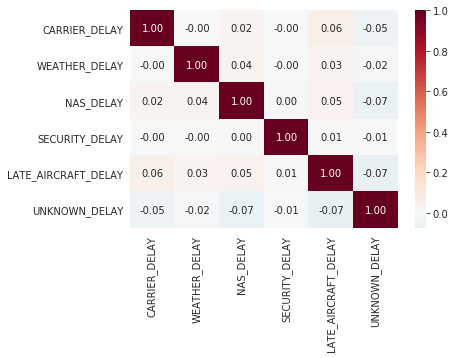

In [14]:
sns.heatmap(df[delay_cols].corr(), center=0, cmap='RdBu_r', annot=True, fmt='.2f')

In [0]:
pivoted = pd.DataFrame(columns=['DELAY', 'VALUE'], index=range(len(delay_cols) * len(df)))

for i, col in enumerate(delay_cols):
    index = range(i*len(df), (i+1)*len(df))
    pivoted.loc[index, 'DELAY'] = col.rstrip('_DELAY')
    pivoted.loc[index, 'VALUE'] = df[col].values
    
pivoted.dropna(inplace=True)

/usr/local/lib/python3.6/dist-packages/matplotlib/tight_layout.py:176: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 



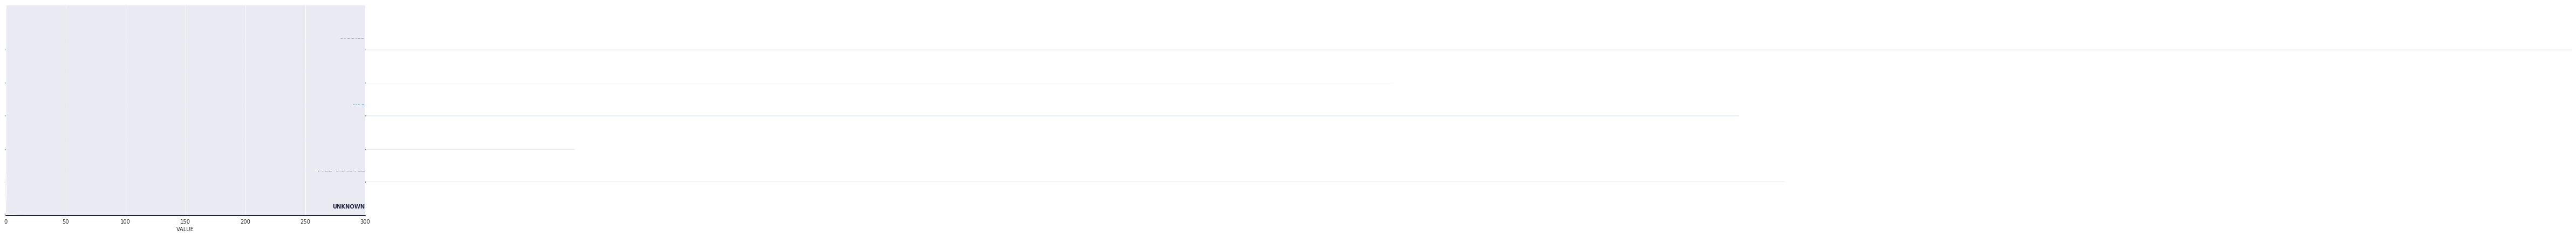

In [16]:
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(6, rot=-.25, light=.7)
g = sns.FacetGrid(pivoted, row='DELAY', hue='DELAY', aspect=10, height=1, palette=pal, xlim=(0,300))

# Draw the densities in a few steps
g.map(sns.kdeplot, 'VALUE', clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, 'VALUE', clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(1, .2, label, fontweight="bold", color=color,
            ha="right", va="center", transform=ax.transAxes)


g.map(label, 'VALUE')

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

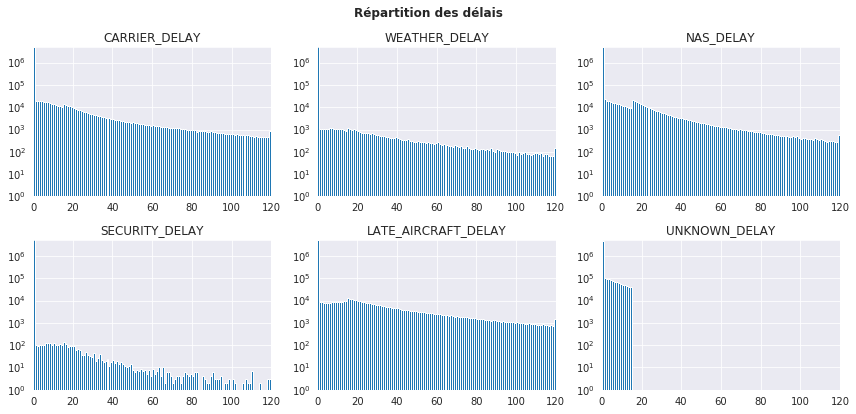

In [17]:
fig, ax = plt.subplots(2, 3, figsize=(12, 6))

for i, col in enumerate(delay_cols):
    ax.flat[i].set_xlim([0, 120])
    ax.flat[i].set_yscale('log')
    ax.flat[i].set_ylim([1, 5e6])
    ax.flat[i].hist(df[col], bins=range(121))
    ax.flat[i].set_title(col)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle("Répartition des délais", weight='bold')
plt.show()

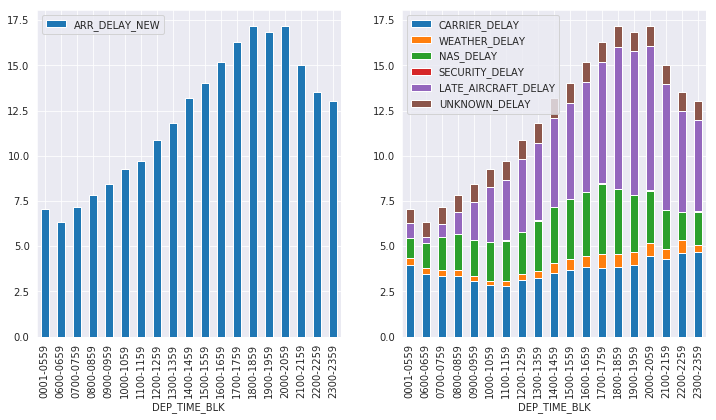

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
df[['ARR_DELAY_NEW', 'DEP_TIME_BLK']].groupby('DEP_TIME_BLK').mean().plot(kind='bar', ax=ax[0])
df[delay_cols + ['DEP_TIME_BLK']].groupby('DEP_TIME_BLK').mean().plot(kind='bar', stacked=True, ax=ax[1])

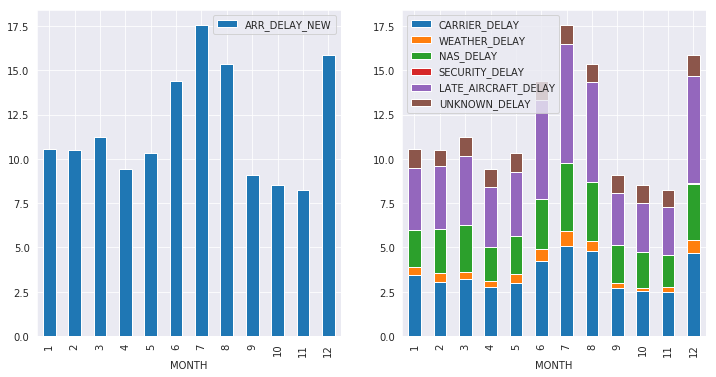

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
df[['ARR_DELAY_NEW', 'MONTH']].groupby('MONTH').mean().plot(kind='bar', ax=ax[0])
df[delay_cols + ['MONTH']].groupby('MONTH').mean().plot(kind='bar', stacked=True, ax=ax[1])

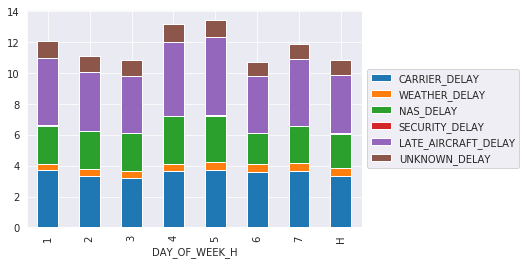

In [23]:
df[delay_cols + ['DAY_OF_WEEK_H']].groupby('DAY_OF_WEEK_H').mean().plot(kind='bar', stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [43]:
pivoted = df[['DEP_TIME_BLK', 'ARR_DELAY_GROUP', 'FLIGHTS']].groupby(['DEP_TIME_BLK', 'ARR_DELAY_GROUP']).sum().unstack()
pivoted.columns = pivoted.columns.droplevel()
pivoted.head()

ARR_DELAY_GROUP     -2.0      -1.0      0.0   ...   10.0   11.0    12.0
DEP_TIME_BLK                                  ...                      
0001-0559         41497.0   74732.0  22388.0  ...  162.0  135.0  1273.0
0600-0659        102737.0  187589.0  61693.0  ...  377.0  321.0  2659.0
0700-0759         95454.0  176148.0  67149.0  ...  455.0  375.0  2273.0
0800-0859         88392.0  168520.0  64600.0  ...  498.0  389.0  2318.0
0900-0959         75116.0  157555.0  64979.0  ...  553.0  410.0  2112.0

[5 rows x 15 columns]

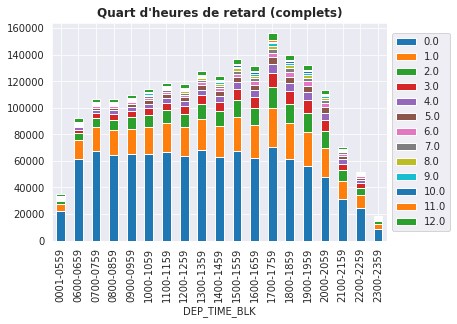

In [44]:
pivoted.iloc[:,2:].plot.bar(stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Quart d'heures de retard (complets)", weight='bold')
plt.show()